# **Sea Level Rise: Station Exploration**

Written by Bailey Armos - [bailey.armos@noaa.gov](bailey.armos@noaa.gov) and Tigist Jima - [tigist.jima@noaa.gov](tigist.jima@noaa.gov)

Coastal Hazards Branch  
Oceanographic Division  
NOAA's Center for Operational Oceanographic Products and Services (CO-OPS)

Last updated on: 2/16/2024

## Overview
NOAA's Center for Operational Oceanographic Products and Services (CO-OPS) is the nation's source for [coastal inundation data and sea level trends](https://tidesandcurrents.noaa.gov/sea_level_info.html) through its network of long-term water level gauges. In this notebook, we will review, plot, and perform statisical analysis on past local sea level data and explore future trajectories. This notebook will walk through how [sea level trends](https://tidesandcurrents.noaa.gov/sltrends/faq.html#q2) are calculated and how different graphics that are part of CO-OPS Sea Level Trends product are produced.

This notebook is designed to explore a single station. Users can choose their station of interest here: [Sea Level Trends Map](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html).

For this example we will use [Sewells Point, VA (8638610)](https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8638610).

## Prerequisites and running the Notebook
This notebook uses Python programming and users may run it either in **Google Colab** or **Jupyter Notebook**. To work offline, manage libraries and dependencies personally; using **Jupyter Notebook** is recommeended. If you want cloud-based instant access, seamless co-operation and have access to good internet connection, **Google Colab** is the best option.

This notebook is designed so that people with limited familiarity with Python can run the notebook. To do so, go to the [github](https://github.com/NOAA-CO-OPS/Coastal_Hazards_Example_Notebooks) page and click on the drop down menu under 'Code', then download the ZIP file. Extract the ZIP file and upload the Sea_Level_Rise_Station_Exploration_Notebook into [google colab](https://colab.research.google.com/). [Explore different station/s](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html) and change the station variable and unit of interest in step 3. Lastly, click **Runtime** in the top menu and choose **Run All**. Then, when the 'Choose Files' box in step 2 becomes active, click on it and upload the TR_local_projections.csv and Station_ID_lookup.csv. You will see a green check mark to the left of each cell as cells are sucessfully executed.

Users should be prepared to commit 1-2 hours to familiarize themselves with the notebook, upload data, run code and examine results.

## Learning Outcomes
In this notebook users will be able to:
  1.  Explore historical sea level data,
  2.  Learn how CO-OPS calculates long-term and hinged Sea Level (SL) trends, and
  3.  Examine future SL trajectories, scenarios, and background relative sea level trends (showing the influence of processes including vertical land motion (VLM))

## Data Source and Documentations
Input and output documentation can be found in the [CO-OPS Data API](https://api.tidesandcurrents.noaa.gov/api/prod/), [CO-OPS Derived Product API v0.1](https://api.tidesandcurrents.noaa.gov/dpapi/prod/) and the [CO-OPS Metadata API](https://api.tidesandcurrents.noaa.gov/mdapi/prod/).

Standard templates are available within the [CO-OPS API URL Builder](https://tidesandcurrents.noaa.gov/api-helper/url-generator.html), but this notebook is designed to give you more flexiblity through building our own API template to generate queries from our Data API, MetaData API, and Derived Product API.

All data used for this notebook come from the CO-OPS API, except for the gauge-based trajectory data from the [2022 Sea Level Rise (SLR) Technical Report](https://oceanservice.noaa.gov/hazards/sealevelrise/sealevelrise-tech-report.html) which can be accessed [here](https://zenodo.org/records/6067895). A csv file that has been extracted from the netcdf is included with this notebook.


## Software
This tutorial uses the following Python packages:
- datetime
- requests
- time
- pandas
- numpy
- matplotlib
- seaborn
- cmocean
- statsmodels
- warnings

## **Step 1**
## Install and Load Packages
Lets check if you have these packages installed. If not, this cell will install them.

In [ ]:
import subprocess, sys
packages = ["datetime","requests","time","pandas","numpy","matplotlib","seaborn","cmocean","statsmodels","warnings"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

Now we load our packages and assign them names to use throughout the notebook.

In [ ]:
import datetime as dt
import requests
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cmocean
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
import warnings
#comment the line below if using Jupyter Notebook
from google.colab import files
#this is to suppress user warnings
warnings.filterwarnings("ignore")

## **Step 2**
## Upload External Data
Here we will upload the Local observations, projections and trajectories (TR_local_projections.csv) data from the 2022 Sea Level Rise (SLR) Technical Report  and Station ID lookup (Station_ID_lookup.csv) file that will be used in step 7. These files can be found on the CO-OPS [Github](https://github.com/NOAA-CO-OPS) page in the Coastal_Hazards_Example_Notebooks repository with this notebook.

In [ ]:
uploaded = files.upload()

## **Step 3**
## Here we choose the station of interest and measurement unit i.e. 'english' (feet) or 'metric' (meter)
Click [here](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html) to see a map of stations to get Station IDs

- Note that stations with limited data in the [National Tidal Datum Epoch (NTDE)](https://tidesandcurrents.noaa.gov/datum_options.html) 1983-2001 will not work in this notebook

In [ ]:
#input station ID below
station = "9751639"

#options are metric or english
units = 'metric'

## **Step 4**
## Next, we pull in our data from the CO-OPS API

### We will start with pulling the monthly Mean Sea Level (MSL) data

In [ ]:
#begin and end date can be adjusted

#some stations have a different pre-defined start date to work within this notebook
#eg: https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=19000101&end_date=20221231&station=8638610&product=monthly_mean&datum=msl&time_zone=gmt&units=english&format=json

#Seward, AK: removing data prior to earthquake https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=9455090
if station == '9455090':
    begin_date = "19640201"
# Redwood City, CA: Sporatic data prior to 1990 making it difficult to visualize the data
elif station == '9414523':
    begin_date = "19900101"
else:
  begin_date = "19000101"
end_date = "20231231"
product = "monthly_mean"
datum = "msl"
server = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?"

myurl = (server + "begin_date=" + begin_date +"&end_date=" + end_date +"&station=" + station +
         "&product=" + product +"&datum=" + datum + "&time_zone=gmt&units="+units+"&format=json")

# Use "requests" to get the Monthly MSL Data
urlResponse = requests.get(myurl)
content=urlResponse.json()

# Assign data to variables.
mydata = content['data']
mymeta= content['metadata']

station_name=mymeta['name']
station_id=mymeta['id']

# Make it a Dataframe
mydf = pd.DataFrame(mydata)

last_year = int(mydf['year'].iloc[-1])
#check out dataframe
mydf

,year,month,highest,MHHW,MHW,MSL,MTL,MLW,MLLW,DTL,GT,MN,DHQ,DLQ,HWI,LWI,lowest,inferred
0,1975,2,0.153,0.065,0.050,-0.051,-0.045,-0.142,-0.167,-0.051,0.232,0.192,0.015,0.024,,,-0.258,0
1,1975,3,0.163,0.092,0.068,-0.020,-0.020,-0.106,-0.127,-0.017,0.219,0.174,0.024,0.021,,,-0.173,0
2,1975,4,0.193,0.141,,0.001,,,-0.121,0.010,0.262,,,,,,-0.206,0
3,1975,5,0.166,0.108,,-0.030,,,-0.145,-0.017,0.253,,,,,,-0.228,1
4,1975,7,0.214,0.114,,-0.026,,,-0.151,-0.020,0.265,,,,,,-0.212,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,2023,8,0.348,0.279,0.243,0.136,0.141,0.040,0.013,0.146,0.266,0.203,0.036,0.027,,,-0.075,0
529,2023,9,0.346,0.269,0.243,0.146,0.153,0.064,0.039,0.154,0.230,0.179,0.026,0.025,,,-0.067,0
530,2023,10,0.366,0.276,0.244,0.137,0.146,0.049,0.024,0.150,0.252,0.195,0.032,0.025,,,-0.083,0
531,2023,11,0.307,0.236,0.209,0.080,0.095,-0.018,-0.044,0.096,0.280,0.227,0.027,0.026,,,-0.153,0


### Below we retrieve the local sea level trend for the station

In [ ]:
#begin and end date can be adjusted
#https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/sealvltrends.json?station=8638610&affil=us
product = "sealvltrends"
affil = "us"
server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/"

myurl = (server + product + ".json?station=" + station + "&affil=" + affil)

# Use "requests" to get the Monthly MSL Data
urlResponse = requests.get(myurl)
content=urlResponse.json()

# Assign data to variables.
mydata = content['SeaLvlTrends']

# Make it a Dataframe
mytrend = pd.DataFrame(mydata)

#check out dataframe
mytrend

,stationId,stationName,affil,latitude,longitude,trend,trendError,units,startDate,endDate
0,9751639,"Charlotte Amalie, VI",US,18.330583,-64.925806,2.16,0.26,mm/yr,02/15/1975,12/15/2023


In [ ]:
#Grabbing station info for our plots
station_info = mytrend['stationId'].iloc[0]+' '+mytrend['stationName'].iloc[0]
start_trend = pd.to_datetime(mytrend['startDate'].iloc[0])
end_trend = pd.to_datetime(mytrend['endDate'].iloc[0])
station_info

'9751639 Charlotte Amalie, VI'

### Below we retrieve datum epoch information

In [ ]:
#grab datum info
server = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/'

myurl = (server + station + '/datums.json?units='+units)

urlResponse = requests.get(myurl)
content=urlResponse.json()

# Assign data to variables.
epoch_info = content['epoch']

#if we can't find the epoch info, default to NTDE
if epoch_info == '0000-0000':
  epoch_info = '1983-2001'

epic_start = int(epoch_info[0:4])
epic_end = int(epoch_info[5:])
epic_length = epic_end - epic_start
epic_mid = int((epic_start + epic_length/2))


## **Step 5**
## Data exploration and visualization

### First, we need to reformat our data.

In [ ]:
#Focusing on the MSL
df_msl=mydf.loc[:,['year','month','MSL']]
#placeholder to represent each month
df_msl['day'] = '01'
df_msl['MSL'] = pd.to_numeric(df_msl['MSL'],downcast='float')
df_msl['year'] = df_msl['year'].astype('int')
df_msl['month'] = df_msl['month'].astype('int')
df_msl['date'] = pd.to_datetime(dict(year=df_msl.year,month=df_msl.month,day=df_msl.day))
df_msl

,year,month,MSL,day,date
0,1975,2,-0.051,01,1975-02-01
1,1975,3,-0.020,01,1975-03-01
2,1975,4,0.001,01,1975-04-01
3,1975,5,-0.030,01,1975-05-01
4,1975,7,-0.026,01,1975-07-01
...,...,...,...,...,...
528,2023,8,0.136,01,2023-08-01
529,2023,9,0.146,01,2023-09-01
530,2023,10,0.137,01,2023-10-01
531,2023,11,0.080,01,2023-11-01


### Now we can plot all of the monthly MSL time-series data.

Text(0.5, 1.0, '9751639 Charlotte Amalie, VI\n Monthly Mean Sea Level over time')

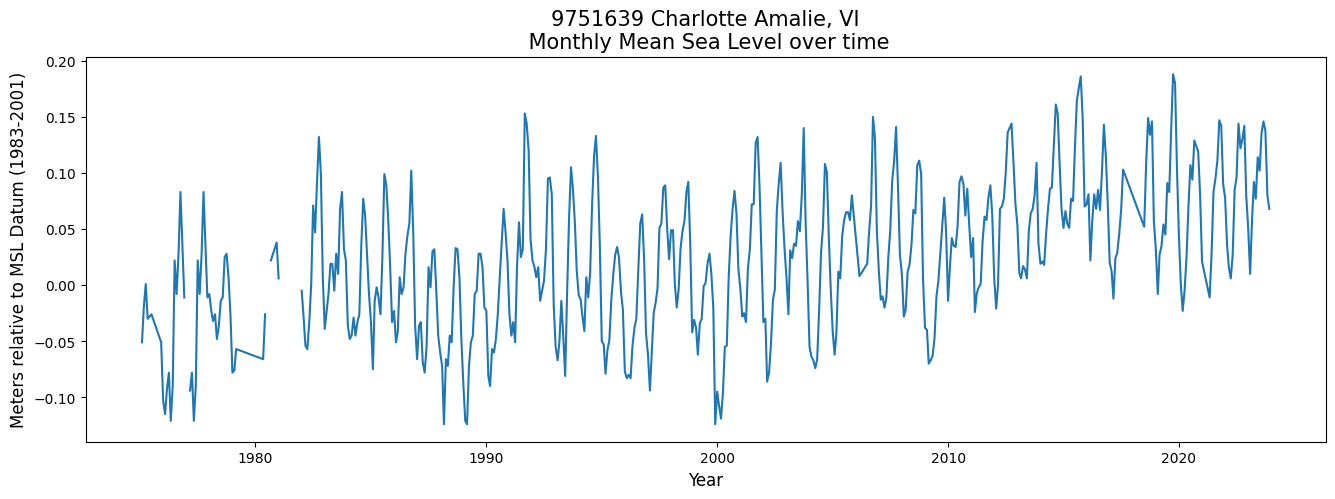

In [ ]:
fig, ax=plt.subplots(figsize=(16,5))
plt.plot(df_msl['date'],df_msl['MSL'])
ax.set_xlabel("Year",fontsize=12)
if units == 'metric':
  ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
else:
  ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
ax.set_title(station_info +'\n ' + "Monthly Mean Sea Level over time",fontsize=15)
#What kind of variation can you see in the plot?
#Seasonal, interanual, long-term variability or trends?

#**Exploring seasonal variations in water levels**
### We will focus on data from the NTDE from 1983-2001 for the next section.

#### What is the NTDE and why is it important?


*   The NTDE is a specific 19-year period used for data collection that corresponds to a full rotation of the longest lunar cycle called the metonic cycle which impacts the range and timing of tides.
*   Aligning the NTDE with the metonic cycle allows NOAA scientists to account for the full range of seasonal and environmental variations that occur at a given coastal location and determine the truest average of tidal conditions.
*   The NTDE is updated periodically to help ensure tidal datums accurately reflect conditions along the Nation's coast.
*   The NTDE time period is useful for examining shorter-term variations such as the seasonal cycle without the impact of long-term variations.

*** Some stations are more frequently updated due to high relative sea level trends

 The [2002 - 2020 NTDE](https://tidesandcurrents.noaa.gov/datum-updates/ntde/index.html) update is coming soon!

Text(0.5, 1.0, '9751639 Charlotte Amalie, VI\n Monthly Mean Sea Level over data epoch: 1983-2001')

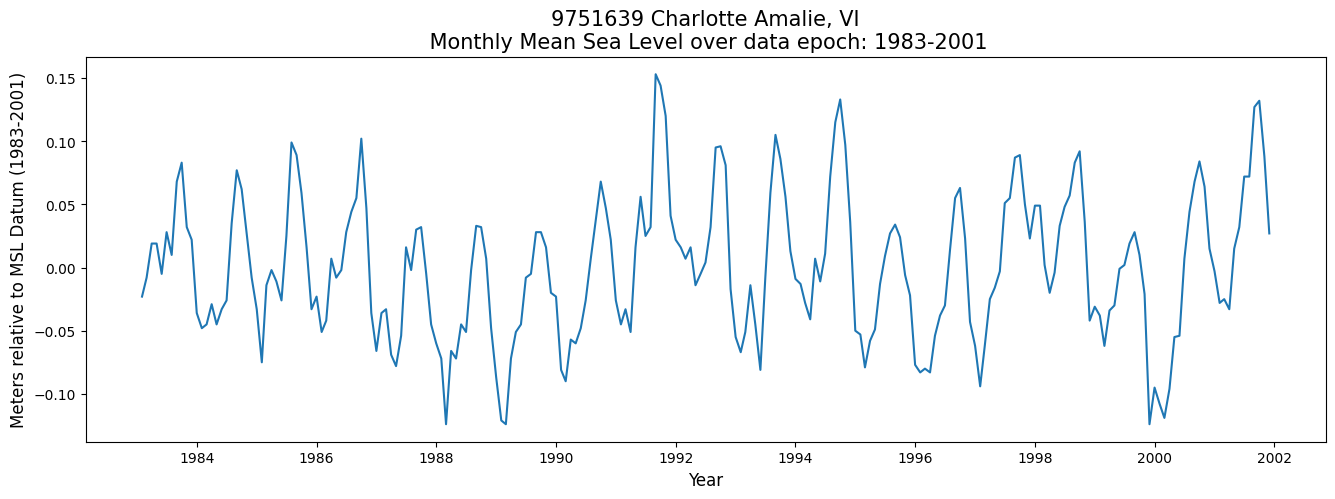

In [ ]:
start_date = str(epic_start)+'-01-01'
end_date = str(epic_end)+'-12-31'

mask = (df_msl['date'] > start_date) & (df_msl['date'] <= end_date)
df_ntde = df_msl.loc[mask]
df_ntde = pd.DataFrame(df_ntde)

fig, ax=plt.subplots(figsize=(16,5))
plt.plot(df_ntde['date'],df_ntde['MSL'])
ax.set_xlabel("Year",fontsize=12)
if units == 'metric':
  ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
else:
  ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
ax.set_title(station_info +'\n '+"Monthly Mean Sea Level over data epoch: "+epoch_info,fontsize=15)

#In this time frame it is harder to visualize the long-term trend, which is useful for examining the average seasonal cycle.

### Next, we can dive into the seasonal cycle.
#### The average seasonal cycle of mean sea level is caused by regular fluctuations in coastal temperatures, salinities, winds, atmospheric pressures and ocean currents over time.

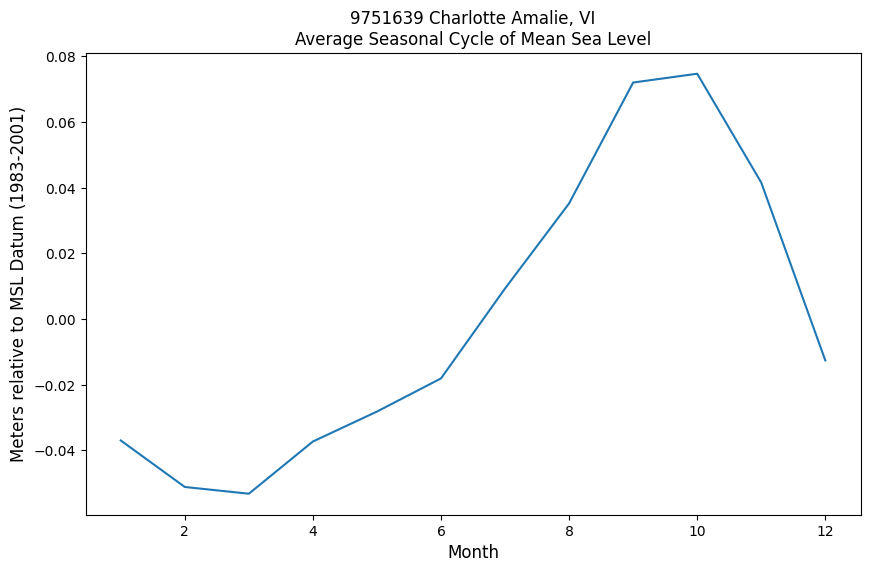

In [ ]:
#average seasonal over NTDE
if station in ['8737048','9414523','8570283','8720218']:
  print('station does not have enough data in NTDE to plot the average seasonal cycle')
else:
  fig, ax =plt.subplots(figsize=(10,6))
  ax.plot(df_ntde.groupby("month").mean(numeric_only=True)["MSL"])
  ax.set_xlabel("Month",fontsize=12)
  if units == 'metric':
    ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
  else:
    ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
  ax.set_title(station_info+"\nAverage Seasonal Cycle of Mean Sea Level")

## Has the seasonal cycle changed over time?

Check out the [climate.gov collaboration](https://www.climate.gov/news-features/features/interactive-map-how-has-local-sea-level-united-states-changed-over-time) for an interactive map showing GIFs of sea level at different stations around the USA.

In [ ]:
#add a decade column
df_msl['decade'] = (df_msl.year//10)*10

In [ ]:
#first finding yearly max and min MSL
mins = pd.DataFrame(df_msl['MSL'].groupby(df_msl['year']).min())
mins.rename(columns = {'MSL':'Min'},inplace=True)

maxs = pd.DataFrame(df_msl['MSL'].groupby(df_msl['year']).max())
maxs.rename(columns = {'MSL':'Max'},inplace=True)

#calculating the range of MSL per year
range = mins.merge(maxs,left_on=mins.index,right_on=maxs.index)
range.rename(columns = {'key_0':'year'},inplace=True)
range['range'] = range['Max']-range['Min']


In [ ]:
#for cool ocean color bar
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap(cmocean.cm.ice)
new_cmap = truncate_colormap(cmap, 0.05, 0.75)
colors= iter(new_cmap(np.linspace(0,1,19)))

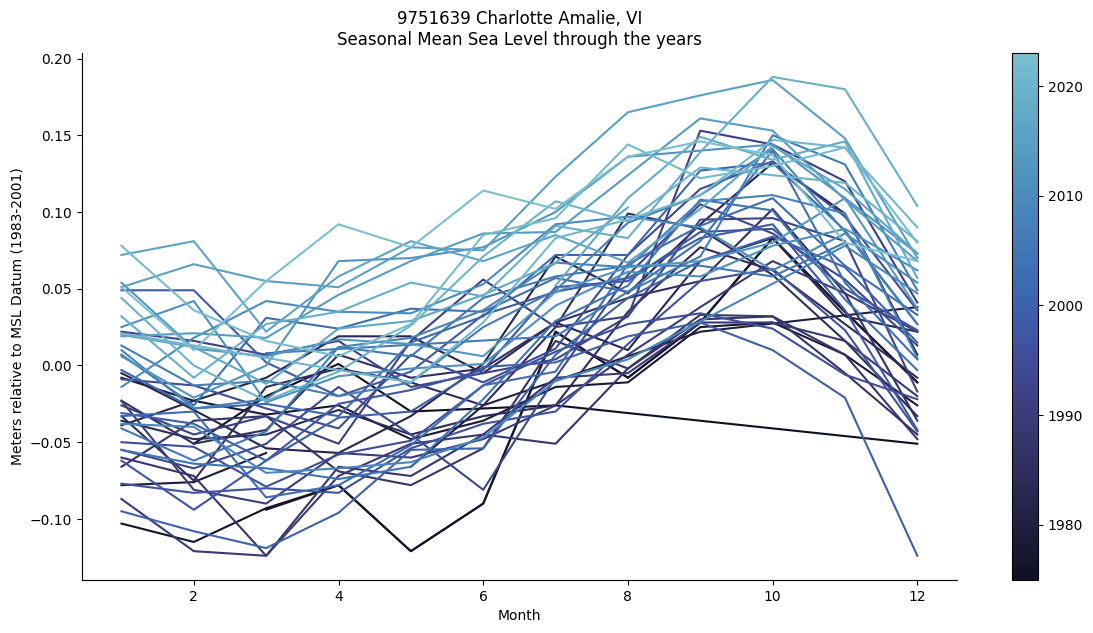

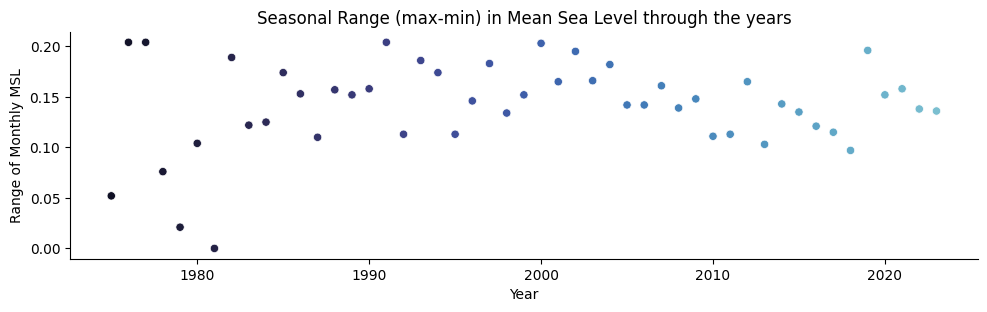

In [ ]:
#now plotting the seasonal cycle over time and the range (max-min) of msl over time
s=sns.relplot(data=df_msl,x='month',y='MSL',hue='year',kind="line",palette=new_cmap, height=6, aspect=12/6)
norm=plt.Normalize(df_msl['year'].min(),df_msl['year'].max())
sm=plt.cm.ScalarMappable(cmap=new_cmap,norm=norm)
sm.set_array([])
s._legend.remove()
s.fig.colorbar(sm)
if units == 'metric':
  s.set(xlabel='Month',ylabel='Meters relative to MSL Datum ('+epoch_info+')',title=station_info+'\nSeasonal Mean Sea Level through the years')
else:
  s.set(xlabel='Month',ylabel='Feet relative to MSL Datum ('+epoch_info+')',title='Seasonal MSL through the years')
warnings.filterwarnings("ignore")

x=sns.relplot(data=range,y='range',x='year',hue='year',palette=new_cmap,height=3, aspect=10/3)
x._legend.remove()
x.set(xlabel='Year',ylabel='Range of Monthly MSL',title='Seasonal Range (max-min) in Mean Sea Level through the years')

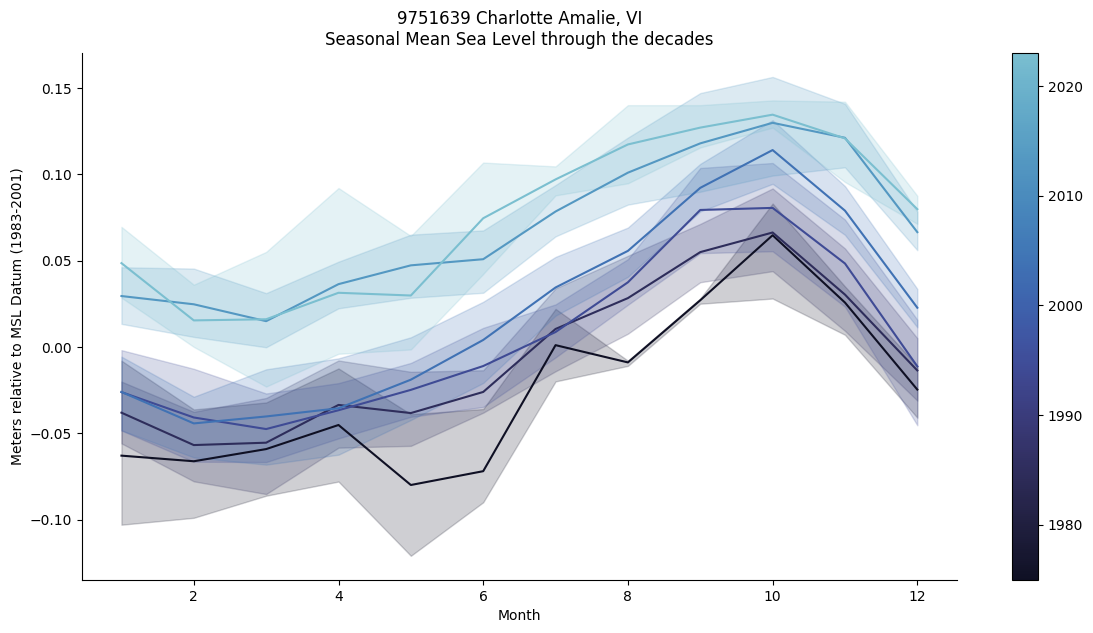

In [ ]:
s=sns.relplot(data=df_msl,x='month',y='MSL',hue='decade',kind="line",palette=new_cmap, height=6, aspect=12/6)
norm=plt.Normalize(df_msl['year'].min(),df_msl['year'].max())
sm=plt.cm.ScalarMappable(cmap=new_cmap,norm=norm)
sm.set_array([])
s._legend.remove()
s.fig.colorbar(sm)
if units == 'metric':
  s.set(xlabel='Month',ylabel='Meters relative to MSL Datum ('+epoch_info+')',title=station_info+'\nSeasonal Mean Sea Level through the decades')
else:
  s.set(xlabel='Month',ylabel='Feet relative to MSL Datum ('+epoch_info+')',title='Seasonal Mean Sea Level through the decades')
warnings.filterwarnings("ignore")

#This plot is showing decadal means and 95% CI for each decade

## **Step 6**

## **Long-term trends in relative water levels**

## Statistical analysis and plotting of long-term linear and hinged trends

#### Walking through the process of calculating the trends as seen in [CO-OPS Sea Level Trends Product](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html)

#### *** The trend calculations in this notebook may vary from the trend calculations on the website listed above.


*   The primary difference is that this notebook is in Python and the trends on the website are calculated using the R programing language. Python and R have different packages/libraries with different capabilities. It is expected to see some variations in using different languages/packages for seasonally decomposing the data and running the Autoregressive Integrated Moving Average (ARIMA) model. The ARIMA model call and order in this notebook is the same as that run in R to produce the trends on the website, just with different packages/libraries.
*   The secondary difference is that on the website some stations have earlier data stored under previous station numbers and were combined to produce sea level trends (these were combined using a known relationship between the stations). This is not currently reflected in the CO-OPS Data API which only grabs data associated with the station number. In this notebook, these stations will produce trends for the data available in the API. For example, [Grand Isle](https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8761724) on the website has data starting in 1947, but the station data on the API starts in 1978.

### First, we will seasonally decompose the MSL data to get the monthly MSL with the average seasonal cycle removed as seen on the website.

This step is important because it removals the regular seasonal fluctuations from coastal ocean temperatures, salinity, wind, atmospheric pressure, and ocean currents from the long-term trend.

In [ ]:
#set index to date
df_msl.set_index(df_msl.date,inplace=True)

msl_date = df_msl[['MSL']].copy()
msl_date.describe()

,MSL
count,529.000000
mean,0.022363
std,0.063779
min,-0.124000
25%,-0.026000
50%,0.022000
75%,0.068000
max,0.188000


In [ ]:
#First, need to set min to 1 as seasonal decomposition model can't handle negative or zero values
#First identify min
min_msl =msl_date.min()
#Second adjust msl data
msl_adjust = msl_date - (min_msl-1)
msl_adjust.describe()

,MSL
count,529.000000
mean,1.146363
std,0.063779
min,1.000000
25%,1.098000
50%,1.146000
75%,1.192000
max,1.312000


In [ ]:
#removing na values
msl_adjust = msl_adjust.dropna()

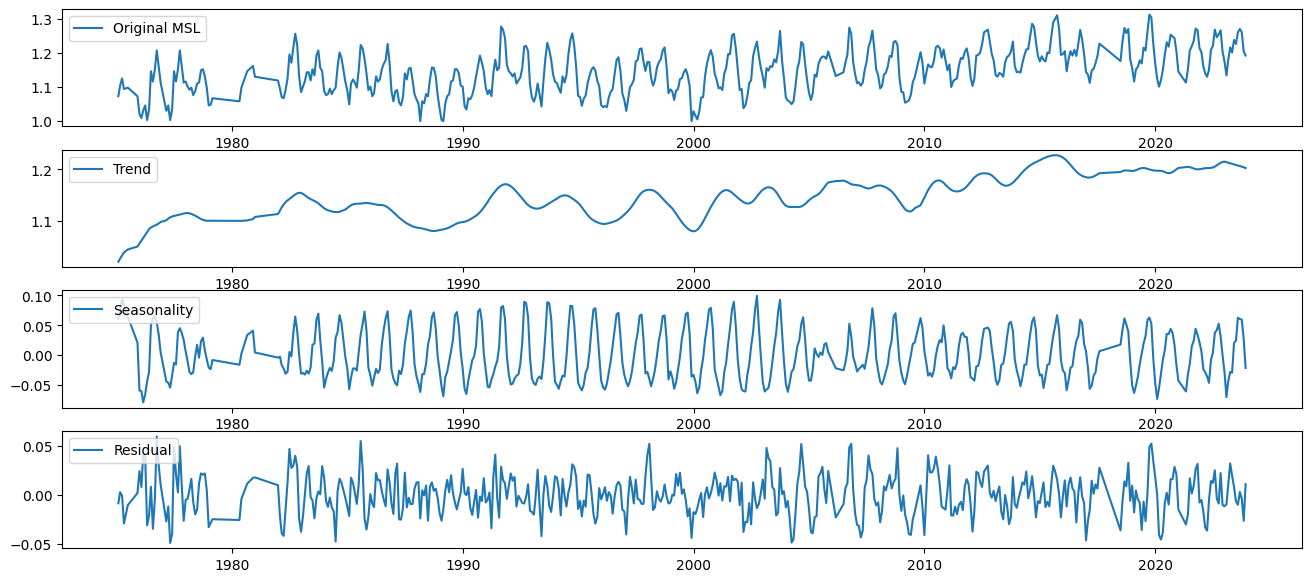

In [ ]:
#Decomposition of trend
#This separates out the trend, seasonal, and residual components from the time series
stl = STL(msl_adjust,period=12)
decomposition = stl.fit()

orig = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig=plt.figure(1)
plt.subplot(411)
plt.plot(msl_adjust,label='Original MSL')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='upper left')

In [ ]:
# Getting the monthly means with the seasonal cycle removed like the data shown on https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8638610
msl_adjust['seasonal_adjust'] = orig['MSL']-seasonal

#offsetting back to MSL datum
epoch = msl_adjust['seasonal_adjust'][str(epic_start):str(epic_end)]

epoch_offset=np.nanmean(epoch)

msl_adjust['msl_seasonal_adjust'] = msl_adjust['seasonal_adjust'] - epoch_offset

### Next, lets calculate our trend using Autoregressive Integrated Moving Average (ARIMA) model

This sub-section will walk through how the SL trends are calculated.

What is an ARIMA model?


*   AR - stands for auto-regression which includes equation terms created based on past data points
*   I - stands for integration or differencing which accounts for the overall trend in the data
*   MA - moving average which is the equation terms of error or noise based on past data points

ARIMA models are represented as ARIMA (p,d,q) where p, d, and q are all parameters that the user has to provide

*  p determines the number of autoregressive (AR) terms
*  d determines the order of differencing
*  q determines the number of moving average (MA) terms

For predicting our sea level trend, we are using ARIMA (0,0,1).

Click [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#) for documentation on the ARIMA model in python.

In [ ]:
#some stations have shorter trends due to events such as earthquakes that create an offset
#we can set our data to the time frame of the offical SL trend which we got from the derived data API

mask = (msl_adjust.index > start_trend) & (msl_adjust.index <= end_trend)
trend_timeframe = msl_adjust.loc[mask]
trend_timeframe = pd.DataFrame(trend_timeframe)
trend_timeframe['decimal_date']=trend_timeframe.index.year+(trend_timeframe.index.dayofyear -1)/365.

In [ ]:
#create matrix for ARIMA model, this is the format that the MSL data is in prior to the ARIMA model
matrix_data = pd.DataFrame()
matrix_data['time1']=trend_timeframe['decimal_date']
matrix_data['month']=trend_timeframe.index.month
matrix_data['msl']=trend_timeframe['msl_seasonal_adjust']

matrix_data['mon1']=matrix_data['month'].apply(lambda x: 1 if x == 1 else 0)
matrix_data['mon2']=matrix_data['month'].apply(lambda x: 1 if x == 2 else 0)
matrix_data['mon3']=matrix_data['month'].apply(lambda x: 1 if x == 3 else 0)
matrix_data['mon4']=matrix_data['month'].apply(lambda x: 1 if x == 4 else 0)
matrix_data['mon5']=matrix_data['month'].apply(lambda x: 1 if x == 5 else 0)
matrix_data['mon6']=matrix_data['month'].apply(lambda x: 1 if x == 6 else 0)
matrix_data['mon7']=matrix_data['month'].apply(lambda x: 1 if x == 7 else 0)
matrix_data['mon8']=matrix_data['month'].apply(lambda x: 1 if x == 8 else 0)
matrix_data['mon9']=matrix_data['month'].apply(lambda x: 1 if x == 9 else 0)
matrix_data['mon10']=matrix_data['month'].apply(lambda x: 1 if x == 10 else 0)
matrix_data['mon11']=matrix_data['month'].apply(lambda x: 1 if x == 11 else 0)
matrix_data['mon12']=matrix_data['month'].apply(lambda x: 1 if x == 12 else 0)

matrix_data = matrix_data.drop('month',axis=1)

msl = pd.DataFrame(matrix_data['msl'])

matrix_data = matrix_data.drop('msl',axis=1)

exog=matrix_data
exog

,time1,mon1,mon2,mon3,mon4,mon5,mon6,mon7,mon8,mon9,mon10,mon11,mon12
date,,,,,,,,,,,,,
1975-03-01,1975.161644,0,0,1,0,0,0,0,0,0,0,0,0
1975-04-01,1975.246575,0,0,0,1,0,0,0,0,0,0,0,0
1975-05-01,1975.328767,0,0,0,0,1,0,0,0,0,0,0,0
1975-07-01,1975.495890,0,0,0,0,0,0,1,0,0,0,0,0
1975-12-01,1975.915068,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,2023.580822,0,0,0,0,0,0,0,1,0,0,0,0
2023-09-01,2023.665753,0,0,0,0,0,0,0,0,1,0,0,0
2023-10-01,2023.747945,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
if units == 'metric':
  #if metric, we want results in mm instead of m
  model=ARIMA(endog=msl*1000,exog=exog,order=(1,0,0))
else:
  #if english, we want in inches instead of ft
  model=ARIMA(endog=msl*12,exog=exog,order=(1,0,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    msl   No. Observations:                  528
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2334.489
Date:                Fri, 16 Feb 2024   AIC                           4700.977
Time:                        19:46:12   BIC                           4769.283
Sample:                             0   HQIC                          4727.718
                                - 528                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4401.2070    549.007     -8.017      0.000   -5477.241   -3325.173
time1          2.3949      0.298      8.048      0.000       1.812       2.978
mon1        -371.7336     46.042     -8.074      0.0

### Curious about the model preformance?

### Here we have the diagnostics of the ARIMA model where we can look for anything unusual in our model

*   The top left plot shows the residuals over time. We want it to appear to be white
noise and not display any seasonality.
*   The top right plot shows a histogram with a KDE and N(0,1) line. The N(0,1)  is the standard notation for a normal distribution with mean 0 and std of 1. If the KDE (Kernel density estimate) follows closely with the N(0,1), it is a good indication that the residuals are normally distributed.
*   The bottom left plot is a qq-plot that shows the ordered distribution of residuals (blue dots) and the linear trend of the samples (red line) taken from a standard normal distribution with N(0,1). If the blue dots follow the linear trend, it is a strong indication that the residuals are normally distributed.
*   The bottom right is a correlogram which shows if the time series residuals have high or low correlation with lagged versions of itself (autocorrelation).


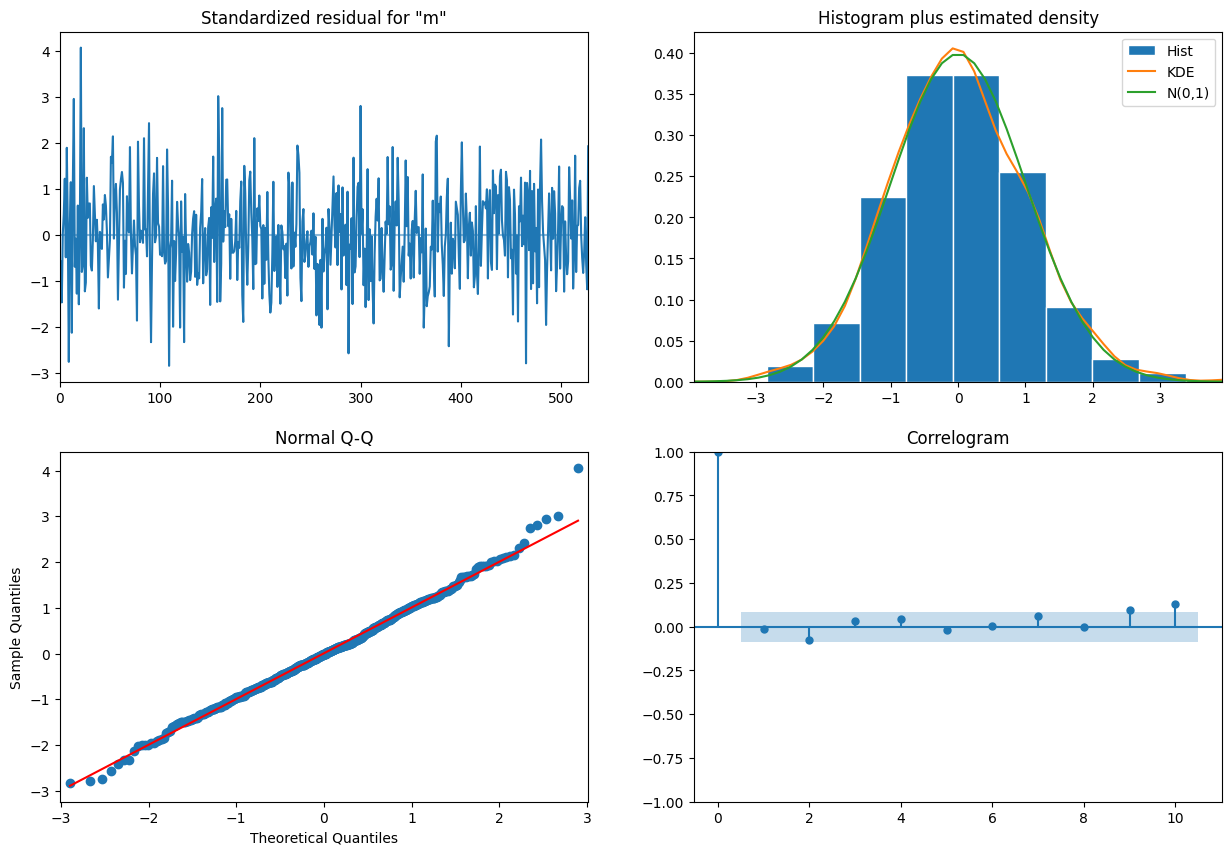

In [ ]:
# KDE = kernel density estimate
# Q-Q plot = quantile/quantile
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

In [ ]:
#get info from model
coefs=model_fit.params
se=model_fit.bse

In [ ]:
#extracting our trend information from model
if units == 'metric':
  trend_text=str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' mm/yr'
  slope_m = coefs[1]/1000
  error_m = (se[1]*1.96)/1000
else:
  trend_text=str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' inches/yr'
  slope_m = coefs[1]/12
  error_m = (se[1]*1.96)/12

trend_text

'2.39 +/- 0.58 mm/yr'

## Plotting linear trend and 95% confidence bands around the regression line

The standard error of the estimate: $S_Y|X$ is calculated as:

$S_Y|X = \sqrt{\frac{\sum_{i=1}^n(Y_i-\hat{Y})^2}{n-2}}$

The standard error of the regression line at point **X** ($S_\hat{Y_x}$) is calculated as:

$S_\hat{Y_x} = S_Y|X \sqrt{\frac{1}{n} + \frac{(X-\bar{X})^2}{\sum_{i=1}^n(X_i - \bar{X})^2}}$

The *95% confidence band* around the regression line is $\hat{Y}\pm 1.96 * S_\hat{Y}$

*assuming data is normally distributed

In [ ]:
#function to find y-int
def getYInt(x1, y1,slope):
    y_intercept = slope * (-x1)+y1
    return (y_intercept)

In [ ]:

lin_y_int = getYInt(epic_mid,0,slope_m)

#calculating liner trend
msl_adjust['linear_trend'] = slope_m*trend_timeframe['decimal_date']+lin_y_int
#manually calculate se of estimate
msl_adjust['y_y2']=(msl_adjust['msl_seasonal_adjust']-msl_adjust['linear_trend'])**2
y_y2_sum = msl_adjust['y_y2'].sum()
msl_adjust['se_regression']=np.sqrt(y_y2_sum/(len(msl_adjust-2)))

In [ ]:
#calculate standard error of the regession line at each point
one_over_n = 1/len(msl_adjust)
msl_adjust['x_x2'] = (msl_adjust['linear_trend']-msl_adjust['linear_trend'].mean())**2
msl_adjust['sum_x_x2'] = msl_adjust['x_x2'].sum()
msl_adjust['sqrt'] = np.sqrt(one_over_n+(msl_adjust['x_x2']/msl_adjust['sum_x_x2']))
msl_adjust['se_point'] = (msl_adjust['se_regression'])*msl_adjust['sqrt']
#confidence bands
msl_adjust['upr'] = msl_adjust['linear_trend']+1.96*msl_adjust['se_point']
msl_adjust['lwr'] = msl_adjust['linear_trend']-1.96*msl_adjust['se_point']

## Now, we will plot our trend

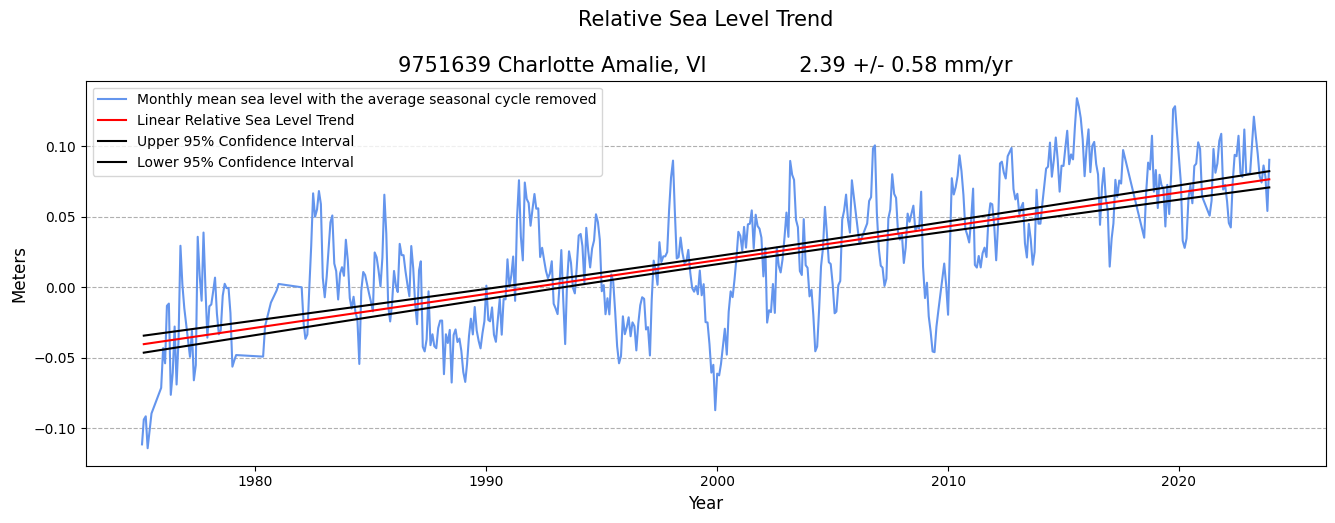

In [ ]:
fig, ax=plt.subplots(figsize=(16,5))
ax.set_xlabel("Year",fontsize=12)
if units == 'metric':
  ax.set_ylabel("Meters",fontsize=12)
else:
  ax.set_ylabel("Feet",fontsize=12)
plt.plot(msl_adjust.index,msl_adjust["msl_seasonal_adjust"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
plt.plot(msl_adjust.index,msl_adjust['linear_trend'],label='Linear Relative Sea Level Trend',color='red')
plt.plot(msl_adjust.index,msl_adjust['upr'],label='Upper 95% Confidence Interval',color='black')
plt.plot(msl_adjust.index,msl_adjust['lwr'],label='Lower 95% Confidence Interval',color='black')
plt.grid(axis='y',linestyle = "--")
ax.set_title("Relative Sea Level Trend\n\n"+station_info+'              '+trend_text,fontsize=15)
plt.legend(loc='best')

## What trend type fits best?

Now, we can explore some hinged linear trends where the linear trend has a breaking point (hinge) at a specific time point. Hinged trends are especially useful for stations that have had more accelerated SL rise like [Charleston, South Carolina](https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8665530).

We will start with a hinged point 50 years ago (1973).

*** Note that advanced users interested in more specific hinged points can simply change 1973 to a different year of choice.

In [ ]:
#For hinged, we need to adjust our matrix by making a time2 column that starts at the desired break point.
#The time1 column should be negative with zero at the breakpoint, and time2 column should be positive starting at the breakpoint.

#create matrix for ARIMA model
matrix_data = pd.DataFrame()
#msl_adjust['decimal_date']=msl_adjust.index.year+(msl_adjust.index.dayofyear -1)/365
matrix_data['time1']=trend_timeframe['decimal_date']
#here the user can change 1973 to a different hinge point
matrix_data['time1']=matrix_data['time1']-1973
matrix_data['time2']=matrix_data['time1']
matrix_data.loc[matrix_data['time1']>0,'time1']=0
matrix_data.loc[matrix_data['time2']<0,'time2']=0
matrix_data['month']=trend_timeframe.index.month
matrix_data['msl']=trend_timeframe['msl_seasonal_adjust']

matrix_data['mon1']=matrix_data['month'].apply(lambda x: 1 if x == 1 else 0)
matrix_data['mon2']=matrix_data['month'].apply(lambda x: 1 if x == 2 else 0)
matrix_data['mon3']=matrix_data['month'].apply(lambda x: 1 if x == 3 else 0)
matrix_data['mon4']=matrix_data['month'].apply(lambda x: 1 if x == 4 else 0)
matrix_data['mon5']=matrix_data['month'].apply(lambda x: 1 if x == 5 else 0)
matrix_data['mon6']=matrix_data['month'].apply(lambda x: 1 if x == 6 else 0)
matrix_data['mon7']=matrix_data['month'].apply(lambda x: 1 if x == 7 else 0)
matrix_data['mon8']=matrix_data['month'].apply(lambda x: 1 if x == 8 else 0)
matrix_data['mon9']=matrix_data['month'].apply(lambda x: 1 if x == 9 else 0)
matrix_data['mon10']=matrix_data['month'].apply(lambda x: 1 if x == 10 else 0)
matrix_data['mon11']=matrix_data['month'].apply(lambda x: 1 if x == 11 else 0)
matrix_data['mon12']=matrix_data['month'].apply(lambda x: 1 if x == 12 else 0)

matrix_data = matrix_data.drop('month',axis=1)

msl = pd.DataFrame(matrix_data['msl'])

matrix_data = matrix_data.drop('msl',axis=1)

exog=matrix_data

In [ ]:
if units == 'metric':
  #if metric, we want results in mm instead of m
  model=ARIMA(endog=msl*1000,exog=exog,order=(1,0,0))
else:
  #if english, want in in instead of ft
  model=ARIMA(endog=msl*12,exog=exog,order=(1,0,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    msl   No. Observations:                  528
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2333.772
Date:                Fri, 16 Feb 2024   AIC                           4701.544
Time:                        19:46:15   BIC                           4774.118
Sample:                             0   HQIC                          4729.955
                                - 528                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -40.1210      8.077     -4.967      0.000     -55.952     -24.290
time1       1.915e-14        nan        nan        nan         nan         nan
time2          2.4233      0.299      8.109      0.0

In [ ]:
#Getting all the information from the model to plot the trendline and confidence bands
msl_adjust['decimal_date']=msl_adjust.index.year+(msl_adjust.index.dayofyear -1)/365.
#finding the trend break
trend_break = msl_adjust.loc[msl_adjust.index=='1973-01-01']

coefs=model_fit.params
se=model_fit.bse

if units == 'metric':
  trend_text1=str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' mm/yr'
  trend_text2=str(np.round(coefs[2],2)) +' +/- '+str(np.round(se[2]*1.96,2))+' mm/yr'
  slope_m1 = coefs[1]/1000
  error_m1 = (se[1]*1.96)/1000
  slope_m2 = coefs[2]/1000
  error_m2 = (se[2]*1.96)/1000

else:
  trend_text1=str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' inches/yr'
  trend_text2=str(np.round(coefs[2],2)) +' +/- '+str(np.round(se[2]*1.96,2))+' inches/yr'
  slope_m1 = coefs[1]/12
  error_m1 = (se[1]*1.96)/12
  slope_m2 = coefs[2]/12
  error_m2 = (se[2]*1.96)/12

year_start = msl_adjust['decimal_date'].iloc[0]

lin_y_int1 = getYInt(epic_mid,0,slope_m1)

msl_adjust['piece_trend'] = slope_m1*trend_timeframe['decimal_date']+lin_y_int1

trend_break = msl_adjust.loc[msl_adjust.index=='1973-01-01']

if len(trend_break) == 0:
    trend_break=msl_adjust[msl_adjust.index>'1973-01-01'].head(1)

lin_y_int2 = getYInt(trend_break.index.year,trend_break['piece_trend'].values[0],slope_m2)
#changing our trend slope at 1973
msl_adjust.loc[msl_adjust.index>'1972-12-31','piece_trend']=slope_m2*trend_timeframe['decimal_date']+lin_y_int2

#manually calculate se of estimate
msl_adjust['y_y2']=(msl_adjust['msl_seasonal_adjust']-msl_adjust['piece_trend'])**2
y_y2_sum = msl_adjust['y_y2'].sum()
msl_adjust['se_regression']=np.sqrt(y_y2_sum/(len(msl_adjust)-2))
se_regression=np.sqrt(y_y2_sum/(len(msl_adjust)-2))

#calculate standard error of the regession line at each point
one_over_n = 1/len(msl_adjust)
msl_adjust['x_x2'] = (msl_adjust['piece_trend']-msl_adjust['piece_trend'].mean())**2
msl_adjust['sum_x_x2'] = msl_adjust['x_x2'].sum()
sum_x_x2=msl_adjust['x_x2'].sum()
msl_adjust['sqrt'] = np.sqrt(one_over_n+(msl_adjust['x_x2']/msl_adjust['sum_x_x2']))
msl_adjust['se_point'] = (msl_adjust['se_regression'])*msl_adjust['sqrt']
#confidence bands
msl_adjust['upr_piece'] = msl_adjust['piece_trend']+1.96*msl_adjust['se_point']
msl_adjust['lwr_piece'] = msl_adjust['piece_trend']-1.96*msl_adjust['se_point']

## Did our trends change?

For Sewells Point, the first piece of the trend is lower while the recent 50-year trend is higher than the long-term trend.

*** Note there must be at least 20 years of data before the hinge point for the hinged trend to plot.

In [ ]:
if start_trend > pd.to_datetime('1953-01-01'):
    print("50-year Piece-wise not applicable at selected station")
elif year_start > 1953:
    print("50-year Piece-wise not applicable at selected station")
else:
    fig, ax=plt.subplots(figsize=(16,5))
    ax.set_xlabel("Year",fontsize=12)
    if units == 'metric':
      ax.set_ylabel("Meters",fontsize=12)
    else:
      ax.set_ylabel("Feet",fontsize=12)
    plt.axvline(x=pd.to_datetime('1973'),color='black',linestyle='dashed')
    plt.plot(msl_adjust.index,msl_adjust["msl_seasonal_adjust"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
    plt.plot(msl_adjust.index,msl_adjust['piece_trend'],label='Linear Relative Sea Level Trend',color='red')
    plt.plot(msl_adjust.index,msl_adjust['upr_piece'],label='Upper 95% Confidence Interval',color='black')
    plt.plot(msl_adjust.index,msl_adjust['lwr_piece'],label='Lower 95% Confidence Interval',color='black')
    plt.grid(axis='y',linestyle = "--")
    ax.set_title("Relative Sea Level Trend\n"+station_info+'\n\n'+'Trend before 1973: '+trend_text1+'              '+'Trend after 1973: '+trend_text2,fontsize=15)
    plt.legend(loc='best')

50-year Piece-wise not applicable at selected station


## Let's try with a hinged point 30 years ago (1993)

### The year 1993 itself is a useful hinge point to use as NOAA began to continuously monitor Earth's sea level with the [TOPEX/Poseidon in 1992](https://sealevel.jpl.nasa.gov/missions/topex-poseidon/summary/). This allows for a comparison with Global Mean Sea Level Rise (GMSLR) rates.

 Click [here](https://www.nesdis.noaa.gov/news/decade-of-global-sea-level-measurements-jason-2-marks-tenth-year-orbit#:~:text=NOAA%20began%20continuously%20monitoring%20Earth's,free%20ocean%20every%2010%20days.) for a NESDIS article on a decade of Global Sea Level measurements.

In [ ]:
#for piecewise we need to adjust our matrix by making a time2 column that starts at the desired break point

#create matrix for ARIMA model
matrix_data = pd.DataFrame()
msl_adjust['decimal_date']=msl_adjust.index.year+(msl_adjust.index.dayofyear -1)/365
matrix_data['time1']=msl_adjust['decimal_date']
matrix_data['time1']=matrix_data['time1']-1993
matrix_data['time2']=matrix_data['time1']
matrix_data.loc[matrix_data['time1']>0,'time1']=0
matrix_data.loc[matrix_data['time2']<0,'time2']=0
matrix_data['month']=msl_adjust.index.month
matrix_data['msl']=msl_adjust['msl_seasonal_adjust']

matrix_data['mon1']=matrix_data['month'].apply(lambda x: 1 if x == 1 else 0)
matrix_data['mon2']=matrix_data['month'].apply(lambda x: 1 if x == 2 else 0)
matrix_data['mon3']=matrix_data['month'].apply(lambda x: 1 if x == 3 else 0)
matrix_data['mon4']=matrix_data['month'].apply(lambda x: 1 if x == 4 else 0)
matrix_data['mon5']=matrix_data['month'].apply(lambda x: 1 if x == 5 else 0)
matrix_data['mon6']=matrix_data['month'].apply(lambda x: 1 if x == 6 else 0)
matrix_data['mon7']=matrix_data['month'].apply(lambda x: 1 if x == 7 else 0)
matrix_data['mon8']=matrix_data['month'].apply(lambda x: 1 if x == 8 else 0)
matrix_data['mon9']=matrix_data['month'].apply(lambda x: 1 if x == 9 else 0)
matrix_data['mon10']=matrix_data['month'].apply(lambda x: 1 if x == 10 else 0)
matrix_data['mon11']=matrix_data['month'].apply(lambda x: 1 if x == 11 else 0)
matrix_data['mon12']=matrix_data['month'].apply(lambda x: 1 if x == 12 else 0)

matrix_data = matrix_data.drop('month',axis=1)

msl = pd.DataFrame(matrix_data['msl'])

matrix_data = matrix_data.drop('msl',axis=1)

exog=matrix_data

if units == 'metric':
  #if metric, we want results in mm instead of m
  model=ARIMA(endog=msl*1000,exog=exog,order=(1,0,0))
else:
  #if english, want in in instead of ft
  model=ARIMA(endog=msl*12,exog=exog,order=(1,0,0))
model_fit = model.fit()

print(model_fit.summary())

trend_break = msl_adjust.loc[msl_adjust.index=='1993-01-01']

coefs=model_fit.params
se=model_fit.bse

if units == 'metric':
  trend_text1=str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' mm/yr'
  trend_text2=str(np.round(coefs[2],2)) +' +/- '+str(np.round(se[2]*1.96,2))+' mm/yr'
  slope_m1 = coefs[1]/1000
  error_m1 = (se[1]*1.96)/1000
  slope_m2 = coefs[2]/1000
  error_m2 = (se[2]*1.96)/1000

else:
  trend_text1=str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' inches/yr'
  trend_text2=str(np.round(coefs[2],2)) +' +/- '+str(np.round(se[2]*1.96,2))+' inches/yr'
  slope_m1 = coefs[1]/12
  error_m1 = coefs[1]/12
  slope_m2 = coefs[2]/12
  error_m2 = (se[2]*1.96)/12

trend_text2

msl_30yr = msl_adjust.copy()

year_start = msl_30yr['decimal_date'].iloc[0]

lin_y_int1 = getYInt(epic_mid,0,slope_m1)

msl_30yr['piece_trend'] = slope_m1*trend_timeframe['decimal_date']+lin_y_int1

trend_break = msl_30yr.loc[msl_30yr.index=='1993-01-01']

if len(trend_break) == 0:
      trend_break=msl_30yr[msl_30yr.index>'1993-01-01'].head(1)

lin_y_int2 = getYInt(trend_break.index.year,trend_break['piece_trend'].values[0],slope_m2)
x=trend_break['piece_trend'].values[0]
if pd.isna(x) == True:
    lin_y_int2 = getYInt(trend_break.index.year,trend_break['linear_trend'].values[0],slope_m2)


msl_30yr.loc[msl_30yr.index>'1992-12-31','piece_trend']=slope_m2*trend_timeframe['decimal_date']+lin_y_int2

#manually calculate se of estimate
msl_30yr['y_y2']=(msl_30yr['msl_seasonal_adjust']-msl_30yr['piece_trend'])**2
y_y2_sum = msl_30yr['y_y2'].sum()
msl_30yr['se_regression']=np.sqrt(y_y2_sum/(len(msl_30yr)-2))
se_regression=np.sqrt(y_y2_sum/(len(msl_30yr)-2))

#calculate standard error of the regession line at each point
one_over_n = 1/len(msl_30yr)
msl_30yr['x_x2'] = (msl_30yr['linear_trend']-msl_30yr['linear_trend'].mean())**2
msl_30yr['sum_x_x2'] = msl_30yr['x_x2'].sum()
sum_x_x2=msl_30yr['x_x2'].sum()
msl_30yr['sqrt'] = np.sqrt(one_over_n+msl_30yr['x_x2']/msl_30yr['sum_x_x2'])
msl_30yr['se_point'] = (msl_30yr['se_regression'])*msl_30yr['sqrt']
#confidence bands
msl_30yr['upr_piece'] = msl_30yr['piece_trend']+1.96*msl_30yr['se_point']
msl_30yr['lwr_piece'] = msl_30yr['piece_trend']-1.96*msl_30yr['se_point']

                               SARIMAX Results                                
Dep. Variable:                    msl   No. Observations:                  529
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2338.007
Date:                Fri, 16 Feb 2024   AIC                           4710.014
Time:                        19:46:18   BIC                           4782.621
Sample:                             0   HQIC                          4738.436
                                - 529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8710      7.479     -0.384      0.701     -17.530      11.788
time1          1.4072      0.778      1.809      0.071      -0.118       2.932
time2          2.8995      0.500      5.803      0.0

## Did our trend change?

For Sewells Point, both pieces increased. How is the 30 year trend different than our initial long-term trend?

In [ ]:
if start_trend > pd.to_datetime('1973-01-01'):
    print("30-year Piece-wise not applicable at selected station")
elif year_start > 1973:
    print("30-year Piece-wise not applicable at selected station")
else:
    fig, ax=plt.subplots(figsize=(16,5))
    ax.set_xlabel("Year",fontsize=15)
    if units == 'metric':
      ax.set_ylabel("Meters",fontsize=15)
    else:
      ax.set_ylabel("Feet",fontsize=15)
    plt.axvline(x=pd.to_datetime('1993'),color='black',linestyle='dashed')
    plt.plot(msl_30yr.index,msl_30yr["msl_seasonal_adjust"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
    plt.plot(msl_30yr.index,msl_30yr['piece_trend'],label='Linear Relative Sea Level Trend',color='red')
    plt.plot(msl_30yr.index,msl_30yr['upr_piece'],label='Upper 95% Confidence Interval',color='black')
    plt.plot(msl_30yr.index,msl_30yr['lwr_piece'],label='Lower 95% Confidence Interval',color='black')
    plt.grid(axis='y',linestyle = "--")
    ax.set_title("Relative Sea Level Trend\n"+station_info+'\n\n'+'Trend before 1993: '+trend_text1+'              '+'Trend after 1993: '+trend_text2,fontsize=18)
    plt.legend(loc='best')

30-year Piece-wise not applicable at selected station


## **Step 7**
## Incorporating future SL observation-based trajectories and scenario-based projections.

### First, we will add in the [2022 Sea Level Rise Technical Report](https://oceanservice.noaa.gov/hazards/sealevelrise/sealevelrise-tech-report-sections.html) SL observation-based trajectories from data fit over 1970-2020 and extrapolated to 2050.

#### As stated earlier, these trajectories are from the csv file with data extracted from the 2022 report (it is not available via API) that we uploaded in the beginning of the notebook.

In [ ]:
trajectories = pd.read_csv('TR_local_projections.csv')
lookup = pd.read_csv('Station_ID_lookup.csv')

In [ ]:
if station in ['9414523','9418767','8726384','8761927','8771510','8772447','8778490','8779748','8570283','8573927','8635027',
                '8411250','8419870','2695540','9455090','8737048']:
    print('No trajectories for this station')
else:
  station_lookup = lookup.loc[lookup['STATION_ID']==int(station)]
  psmsl_id = station_lookup['PSMSL_id'].values[0]
  if psmsl_id == -1:
    station_tg = station_lookup['Station_NAME_tg'].values[0]
    station_df = trajectories.loc[trajectories['tg']==station_tg]
  else:
    station_df = trajectories.loc[trajectories['PSMSL_id']==psmsl_id]
  station_df['day'] = '01'
  station_df['month'] = '01'

  pd.options.mode.chained_assignment = None
  station_df['date'] = pd.to_datetime(dict(year=station_df.years,month=station_df.month,day=station_df.day))
  station_df = station_df.set_index('date')

  if units == 'metric':
    #convert mm to m
    station_df['rsl_trajectory_m'] = station_df['rsl_trajectory']*0.001
    station_df['rsl_obs_m'] = station_df['rsl_obs']*0.001
  else:
    #convert mm to ft
    station_df['rsl_trajectory_m'] = station_df['rsl_trajectory']*0.00328084
    station_df['rsl_obs_m'] = station_df['rsl_obs']*0.00328084
  #for plotting with future scenarios, all data will need to be offset to center around 2005

  epoch_96_14=station_df['1996':'2014']
  epoch_offset=np.nanmean(epoch_96_14['rsl_obs_m'])

  station_df['rsl_trajectory_offset'] = station_df['rsl_trajectory_m'] - epoch_offset

  median_df = station_df[station_df['percentiles']== 50]
  high_df = station_df[station_df['percentiles']== 83]
  low_df = station_df[station_df['percentiles']== 17]

In [ ]:
epoch_96_14=msl_adjust['1996':'2014']
epoch_offset_msl=np.nanmean(epoch_96_14['msl_seasonal_adjust'])

#offseting msl data to center at 2005
msl_adjust['msl_offset']=msl_adjust.msl_seasonal_adjust-epoch_offset_msl
msl_adjust['trend_offset']=msl_adjust.linear_trend-epoch_offset_msl
msl_adjust['upr_offset']=msl_adjust.upr-epoch_offset_msl
msl_adjust['lwr_offset']=msl_adjust.lwr-epoch_offset_msl

In [ ]:
msl_adjust=msl_adjust.dropna(subset=['msl_offset'])
msl_adjust['annual_msl']=msl_adjust.groupby(by=msl_adjust.index.year)['msl_offset'].transform('mean')
msl_adjust['day'] = '01'
msl_adjust['month'] = '01'
msl_adjust['year_date'] = pd.to_datetime(dict(year=msl_adjust.index.year,month=msl_adjust.month,day=msl_adjust.day))

#for trajectories
msl_adjust_recent = msl_adjust[msl_adjust.index>'1969-12-31']

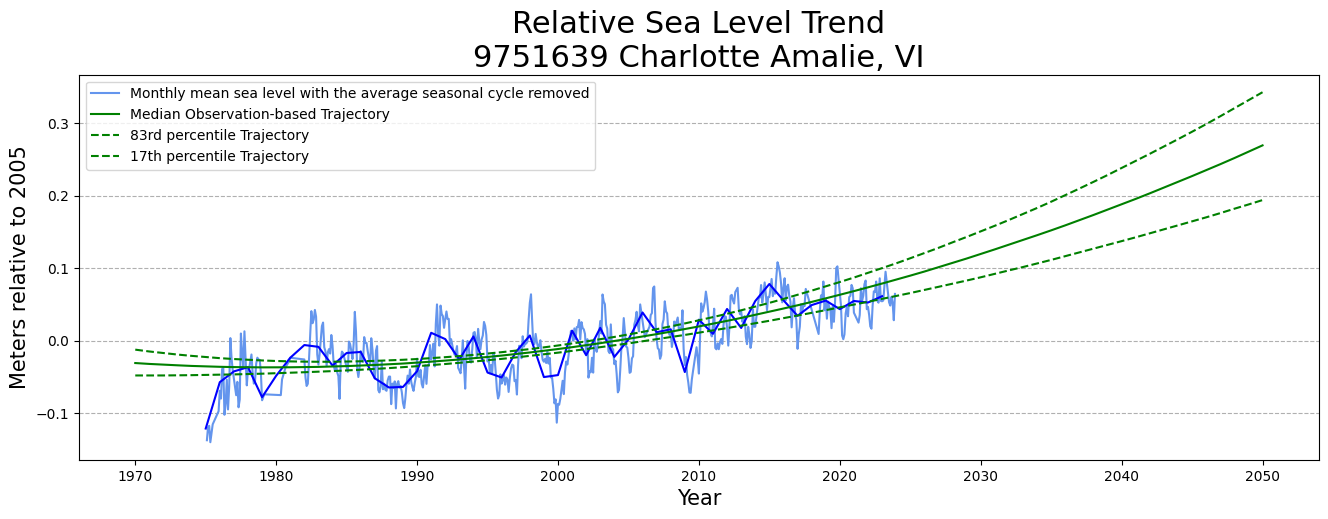

In [ ]:
if station in ['9414523','9418767','8726384','8761927','8771510','8772447','8778490','8779748','8570283','8573927','8635027',
                '8411250','8419870','2695540','9455090','8737048']:
    print('No trajectories for this station')
else:
  fig, ax=plt.subplots(figsize=(16,5))
  ax.set_xlabel("Year",fontsize=15)
  if units == 'metric':
    ax.set_ylabel("Meters relative to 2005",fontsize=15)
  else:
    ax.set_ylabel("Feet relative to 2005",fontsize=15)
  plt.plot(msl_adjust_recent.index,msl_adjust_recent["msl_offset"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
  plt.plot(msl_adjust_recent.year_date,msl_adjust_recent['annual_msl'],color='blue')
  plt.plot(median_df.index,median_df['rsl_trajectory_offset'],color='green',label='Median Observation-based Trajectory')
  plt.plot(high_df.index,high_df['rsl_trajectory_offset'],color='green',linestyle='dashed',label='83rd percentile Trajectory')
  plt.plot(low_df.index,low_df['rsl_trajectory_offset'],color='green',linestyle='dashed',label='17th percentile Trajectory')
  plt.grid(axis='y',linestyle = "--")
  ax.set_title("Relative Sea Level Trend\n"+station_info,fontsize=22)
  plt.legend(loc='best')

## Now, we will plot the 2022 SLR report SLR projections for each 5 scenarios

In [ ]:
if station in ['9463502','9437540','8737048','8726384','8726674','8729210','8761927','8772447','8778490','8779748','8570283',
               '8573927','8631044','8635027','8637689','8419870','8423898','2695540']:
    print('This station does not have regional scenarios. Please choose another station to proceed through the notebook.')

else:
# Get SLR Projections from 2022 Tech Report
    product = "slr_projections"

    server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/"
    #eg: https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/slr_projections.json?units=metric&station=8638610&&report_year=2022&affil=us

    affil = "US"

    report_year='2022'

    myurl=(server+ product  + ".json?"+"units="+units+"&station=" + station + "&report_year=" + report_year+"&affil=" + affil)
    # Use requests to get the data
    urlResponse = requests.get(myurl)
    content=urlResponse.json()

    # Assign data to variables
    mydata = content['SlrProjections']

    # Make it a Dataframe
    mydf_slr_projection = pd.DataFrame(mydata)
    mydf_slr_projection['day'] = '01'
    mydf_slr_projection['month'] = '01'
    mydf_slr_projection['year_date'] = pd.to_datetime(dict(year=mydf_slr_projection.projectionYear,
                                                           month=mydf_slr_projection.month,day=mydf_slr_projection.day))
    mydf_slr_projection=mydf_slr_projection[mydf_slr_projection['year_date']<'2101-01-01']

    # Break down SLR Projections by Scenario
    scenario_low=mydf_slr_projection[mydf_slr_projection['scenario']=='Low']
    scenario_low.reset_index(inplace=True,drop=True)
    scenario_intlow=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate-Low']
    scenario_intlow.reset_index(inplace=True,drop=True)
    scenario_int=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate']
    scenario_int.reset_index(inplace=True,drop=True)
    scenario_inthigh=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate-High']
    scenario_inthigh.reset_index(inplace=True,drop=True)
    scenario_high=mydf_slr_projection[mydf_slr_projection['scenario']=='High']
    scenario_high.reset_index(inplace=True,drop=True)

    if units == 'metric':
      #converting from cm to m
      scenario_low_rslproj=scenario_low['projectionRsl']*0.01
      scenario_intlow_rslproj=scenario_intlow['projectionRsl']*0.01
      scenario_int_rslproj=scenario_int['projectionRsl']*0.01
      scenario_inthigh_rslproj=scenario_inthigh['projectionRsl']*0.01
      scenario_high_rslproj=scenario_high['projectionRsl']*0.01
    else:
      #converting from in to ft
      scenario_low_rslproj=scenario_low['projectionRsl']*0.0833333
      scenario_intlow_rslproj=scenario_intlow['projectionRsl']*0.0833333
      scenario_int_rslproj=scenario_int['projectionRsl']*0.0833333
      scenario_inthigh_rslproj=scenario_inthigh['projectionRsl']*0.0833333
      scenario_high_rslproj=scenario_high['projectionRsl']*0.0833333

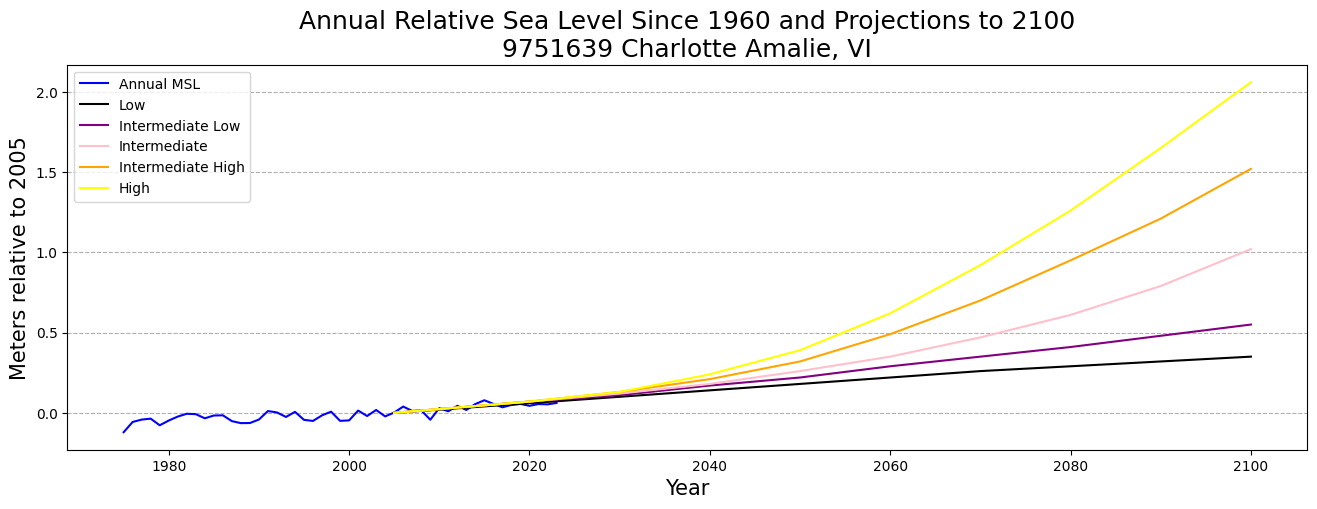

In [ ]:
if station in ['9463502','9437540','8737048','8726384','8726674','8729210','8761927','8772447','8778490','8779748','8570283',
               '8573927','8631044','8635027','8637689','8419870','8423898','2695540','2695540']:
    print('This station does not have regional scenarios. Please choose another station to proceed through the notebook.')
else:
    fig, ax=plt.subplots(figsize=(16,5))
    ax.set_xlabel("Year",fontsize=15)
    if units == 'metric':
      ax.set_ylabel("Meters relative to 2005",fontsize=15)
    else:
      ax.set_ylabel("Feet relative to 2005",fontsize=15)

    plt.plot(msl_adjust_recent.year_date,msl_adjust_recent['annual_msl'],color='blue',label='Annual MSL')
    plt.plot(scenario_low.year_date,scenario_low_rslproj,label='Low',color='black')
    plt.plot(scenario_intlow.year_date,scenario_intlow_rslproj,label='Intermediate Low',color='purple')
    plt.plot(scenario_int.year_date,scenario_int_rslproj,label='Intermediate',color='pink')
    plt.plot(scenario_inthigh.year_date,scenario_inthigh_rslproj,label='Intermediate High',color='orange')
    plt.plot(scenario_high.year_date,scenario_high_rslproj,label='High',color='yellow')
    plt.grid(axis='y',linestyle = "--")
    ax.set_title("Annual Relative Sea Level Since 1960 and Projections to 2100\n"+station_info,fontsize=18)
    plt.legend(loc='best')

## Let's incorporate the background relative sea level from the 2022 SLR report
### We can use the background relative sea level (RSL) to examine the contribution of Vertical Land Motion to sea level.

### Tide gauge trends are relative to a fixed point on land and reflect both the changes in water level and local VLM. VLM can vary due to different factors such glacial rebound, earthquakes, and ground-water withdrawal. A positive background sea level trend indicates that the land is sinking, thus contributing positively to sea level rise. A negative background sea level trend means the land is rising, thus contributing negatively to sea level rise.

In [ ]:
mask = (msl_adjust.index > start_trend) & (msl_adjust.index <= end_trend)
trend_timeframe = msl_adjust.loc[mask]
trend_timeframe = pd.DataFrame(trend_timeframe)
trend_timeframe['decimal_date']=trend_timeframe.index.year+(trend_timeframe.index.dayofyear -1)/365.

In [ ]:
if station in ['9463502','9437540','8737048','8726384','8726674','8729210','8761927','8772447','8778490','8779748','8570283',
               '8573927','8631044','8635027','8637689','8419870','8423898','2695540']:
  print('This station does not have background SL data. Please choose another station to proceed through the notebook.')
else:
  if units == 'metric':
    #all we have is the trend slope in cm/year
    rsl = mydf_slr_projection['backgroundRslPerYear'][0] * 0.01
    rsl_mm = mydf_slr_projection['backgroundRslPerYear'][0] * 10
    rsl_text=str(np.round(rsl_mm,2))+' mm/yr'
  else:
    rsl = mydf_slr_projection['backgroundRslPerYear'][0] * 0.0833333
    rsl_mm = mydf_slr_projection['backgroundRslPerYear'][0]
    rsl_text=str(np.round(rsl_mm,2))+' inches/yr'

  lin_trend = trend_timeframe['trend_offset'].iloc[0]
  year_start = trend_timeframe['decimal_date'].iloc[0]

  y_int = getYInt(year_start,lin_trend,rsl)
  msl_adjust['backgroundRsl']= rsl*trend_timeframe['decimal_date']+y_int



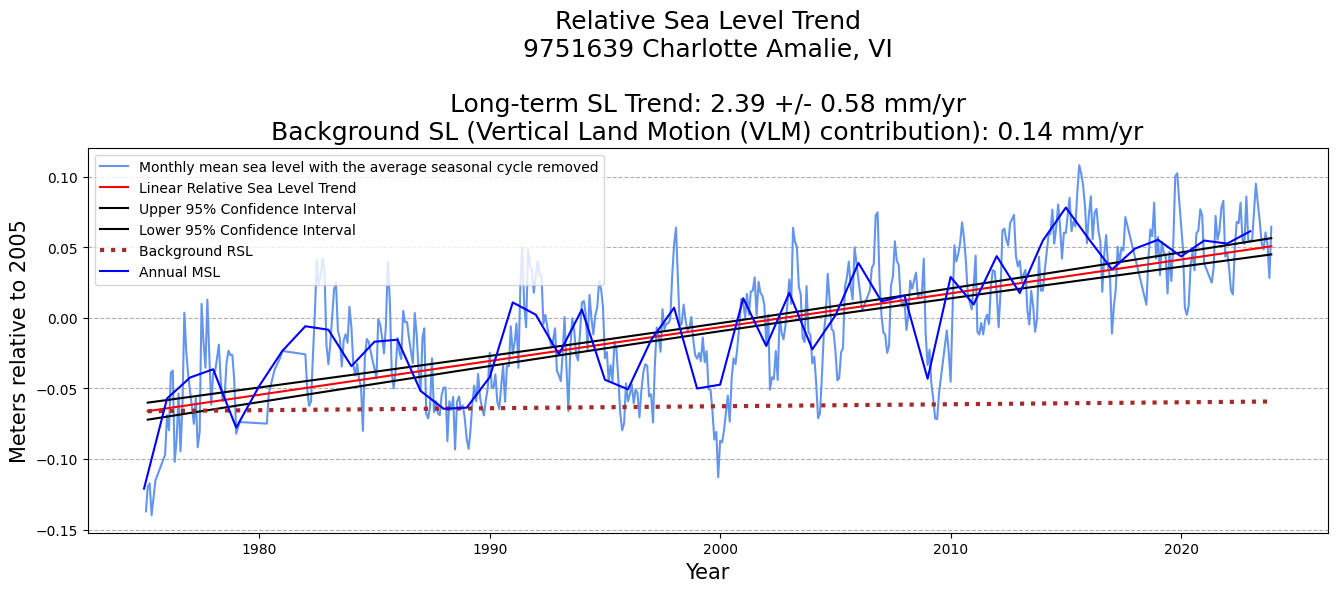

In [ ]:
if station in ['9463502','9437540','8737048','8726384','8726674','8729210','8761927','8772447','8778490','8779748','8570283',
               '8573927','8631044','8635027','8637689','8419870','8423898','2695540']:
    print('This station does not have background SL data. Please choose another station to proceed through the notebook.')
else:
    fig, ax=plt.subplots(figsize=(16,5))
    ax.set_xlabel("Year",fontsize=15)
    if units == 'metric':
      ax.set_ylabel("Meters relative to 2005",fontsize=15)
    else:
      ax.set_ylabel("Feet relative to 2005",fontsize=15)
    plt.plot(msl_adjust.index,msl_adjust["msl_offset"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
    plt.plot(msl_adjust.index,msl_adjust['trend_offset'],label='Linear Relative Sea Level Trend',color='red')
    plt.plot(msl_adjust.index,msl_adjust['upr_offset'],label='Upper 95% Confidence Interval',color='black')
    plt.plot(msl_adjust.index,msl_adjust['lwr_offset'],label='Lower 95% Confidence Interval',color='black')
    plt.plot(msl_adjust.index,msl_adjust['backgroundRsl'],color='brown',linestyle='dotted',linewidth='3',label='Background RSL')
    plt.plot(msl_adjust.year_date,msl_adjust['annual_msl'],color='blue',label='Annual MSL')
    plt.grid(axis='y',linestyle = "--")
    ax.set_title("Relative Sea Level Trend\n"+station_info+'\n\n'+'Long-term SL Trend: '+trend_text + '\n'+'Background SL (Vertical Land Motion (VLM) contribution): '+rsl_text,fontsize=18)
    plt.legend(loc='best')

## Now, we can plot everything together!

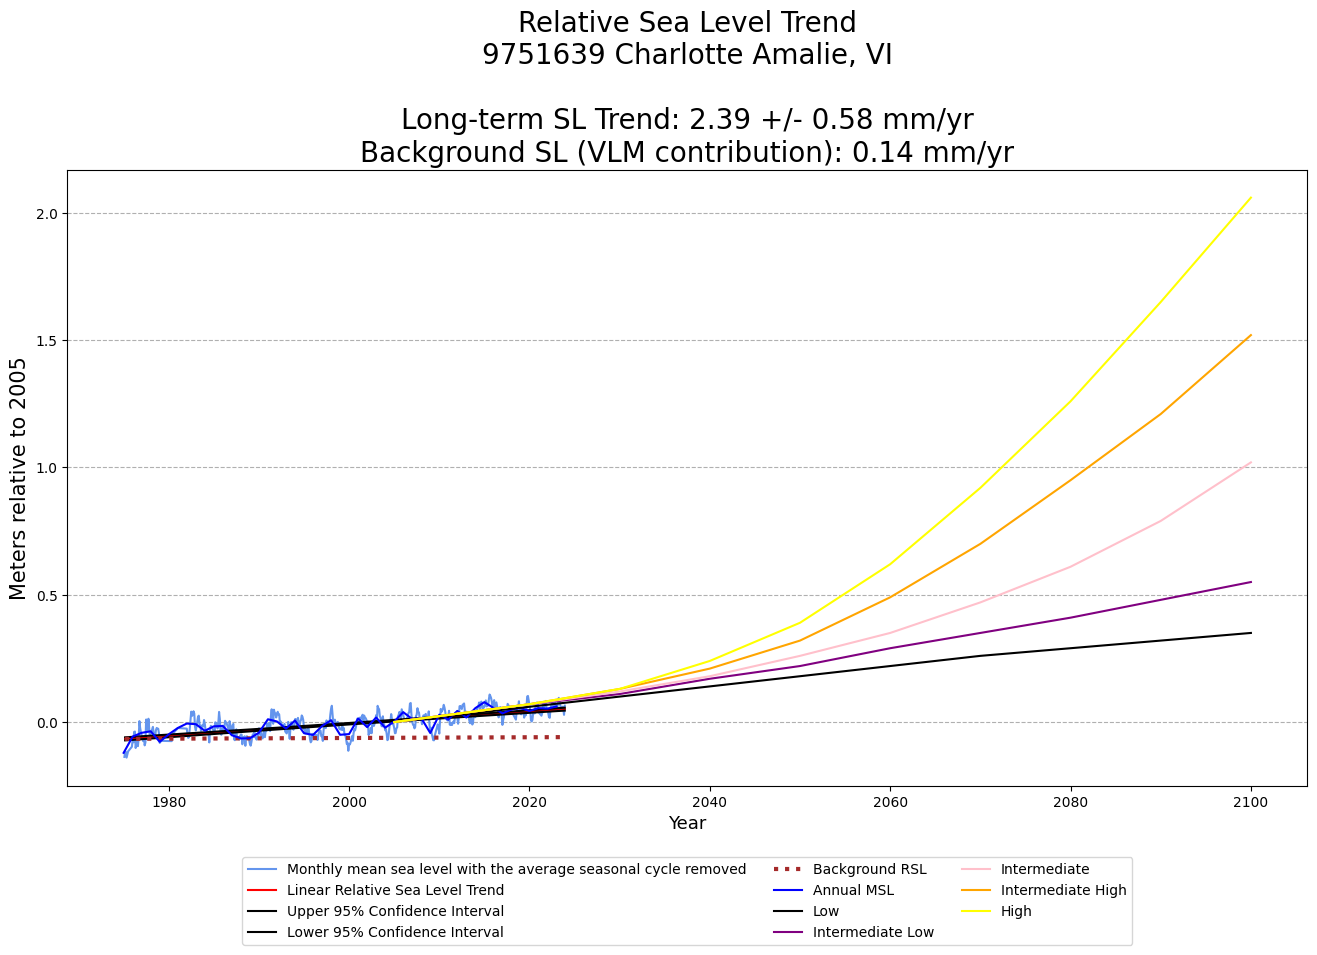

In [ ]:
if station in ['9463502','9437540','8737048','8726384','8729210','8761927','8772447','8778490','8779748','8570283','8573927',
              '8631044','8635027','8637689','8419870','8423898','2695540','9414523','9418767','8726384','8761927','8771510','8772447','8778490','8779748','8570283','8573927','8635027',
                '8411250','8419870','2695540','9455090']:
    print('This station does not have trajectories and/or regional scenarios. Please choose another station to proceed through the notebook.')
else:
    fig, ax=plt.subplots(figsize=(16,8))
    ax.set_xlabel("Year",fontsize=13)
    if units == 'metric':
      ax.set_ylabel("Meters relative to 2005",fontsize=15)
    else:
      ax.set_ylabel("Feet relative to 2005",fontsize=15)
    plt.plot(msl_adjust.index,msl_adjust["msl_offset"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
    plt.plot(msl_adjust.index,msl_adjust['trend_offset'],label='Linear Relative Sea Level Trend',color='red')
    plt.plot(msl_adjust.index,msl_adjust['upr_offset'],label='Upper 95% Confidence Interval',color='black')
    plt.plot(msl_adjust.index,msl_adjust['lwr_offset'],label='Lower 95% Confidence Interval',color='black')
    plt.plot(msl_adjust.index,msl_adjust['backgroundRsl'],color='brown',linestyle='dotted',linewidth='3',label='Background RSL')
    plt.plot(msl_adjust.year_date,msl_adjust['annual_msl'],color='blue',label='Annual MSL')
    plt.plot(scenario_low.year_date,scenario_low_rslproj,label='Low',color='black')
    plt.plot(scenario_intlow.year_date,scenario_intlow_rslproj,label='Intermediate Low',color='purple')
    plt.plot(scenario_int.year_date,scenario_int_rslproj,label='Intermediate',color='pink')
    plt.plot(scenario_inthigh.year_date,scenario_inthigh_rslproj,label='Intermediate High',color='orange')
    plt.plot(scenario_high.year_date,scenario_high_rslproj,label='High',color='yellow')
    plt.grid(axis='y',linestyle = "--")
    ax.set_title("Relative Sea Level Trend\n"+station_info+'\n\n'+'Long-term SL Trend: '+trend_text + '\n'+'Background SL (VLM contribution): '+rsl_text,fontsize=20)
    #plt.legend(loc='upper center',ncol=3,fontsize=13)
    plt.legend(bbox_to_anchor=(0.5,-0.27),loc='lower center',ncol=3,fontsize=10)

## **Takeaways**

###Thank you for taking the time to walk through this Sea Level Station Exploration notebook.

###Some key takeaways include:

*   How to access CO-OPS data from the CO-OPS API (here is a [URL builder](https://tidesandcurrents.noaa.gov/api-helper/url-generator.html) if you want to explore other CO-OPS data)
*   Understanding different station's seasonal cycles and how they have changed over time

*   How to seasonally decompose and run ARIMA models to get SL trends
*   How hinged trends can provide information about SL trends in different time periods
*   How to plot data from the 2022 Sea Level Report with CO-OPS sea level data to gain better understanding of how sea level could change in the future



